In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
import numpy as np
import math
from scipy import stats
import scipy.special

In [4]:
# I worked mostly using dictionaries, but I want to switch to DataFrames now, because it's easier to plot them. 
# I might also want to convert to ndarrays to handling the data, so instead of changing the code, 
# I created this function to convert to different data types:

def convert(my_dict, to_type='DataFrame'):
    if to_type=='DataFrame':
        return pd.DataFrame.from_dict(my_dict, orient='index', columns=['P'])
    else:
        raise ValuError(f'Datatype{to_type} not supported')

# Open the files

In [5]:
temp = open('A.fna','r').read().split('\n')
A = ''.join(temp)

temp = open('B.fna','r').read().split('\n')
B = ''.join(temp)

#The string C will be used for testing the functions
C='HOOOOLA\nwey'

# Basic tests

## Make sure the files have a DNA structure

In [6]:
def isDNA(Z):
    ''' Checks whether the sequence Z contains only vald nucleotides (A,T,G or C)
    Returns a boolean and a message pointing out letters which are not valid nucleotides'''
    nonNuc=[]
    for N in Z:
        if N!='A' and N!='T' and N!='G' and N!='C':# and N!='\n':
            nonNuc.append(N)
    if len(nonNuc)==0: # If I didn't find any character not corresponding to a nucleotide, consider it as a valid DNA sequence
        toPrint='All letters are valid nucleotides'
        return(True, toPrint)
    else:
        toPrint = f'The sequence contains the letters: {nonNuc}, which are not a valid nucleotides'
        return(False, toPrint)

print(f'is A a valid DNA sequence? -> {isDNA(A)}')
print(f'is B a valid DNA sequence? -> {isDNA(B)}')
print(f'is C a valid DNA sequence? -> {isDNA(C)}')

# Check if one file is bigger than the other
print('')
print(f'A contains {len(A)} nucleotides')
print(f'B contains {len(B)} nucleotides')

# Define N as the number of nucleotides in the sequences
N = len(A)

is A a valid DNA sequence? -> (True, 'All letters are valid nucleotides')
is B a valid DNA sequence? -> (True, 'All letters are valid nucleotides')
is C a valid DNA sequence? -> (False, "The sequence contains the letters: ['H', 'O', 'O', 'O', 'O', 'L', '\\n', 'w', 'e', 'y'], which are not a valid nucleotides")

A contains 981133 nucleotides
B contains 981133 nucleotides


So both files contain a valid sequence of nucleotides and they are the same length

## Probability of finding a given nucleotide

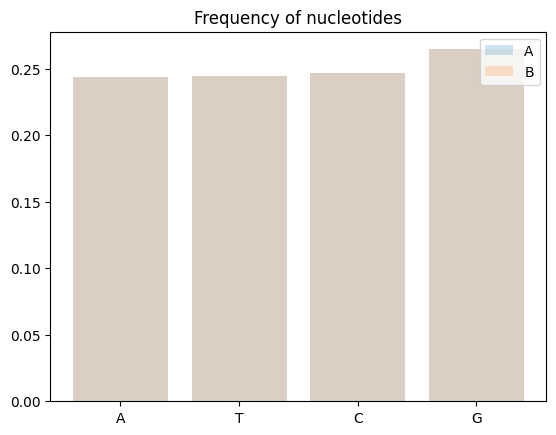

Probabilities in file A: {'A': 0.24399750084850882, 'T': 0.24446736579036685, 'C': 0.24694715191518377, 'G': 0.26458798144594053}
Probabilities in file B; {'A': 0.24399750084850882, 'T': 0.24446736579036685, 'C': 0.24694715191518377, 'G': 0.26458798144594053}


In [7]:
def probNuc(Z, N):
    ''' Returns the empirical probability of finding a nucleotide N in the sequence'''
    num_N = Z.count(N)/len(Z)
    return num_N

A_single_probs = {}
B_single_probs = {}

for nuc in ['A', 'T', 'C', 'G']:
    A_single_probs[nuc] = probNuc(A,nuc)
    B_single_probs[nuc] = probNuc(B,nuc)

plt.bar(A_single_probs.keys(), A_single_probs.values(), alpha=0.2, label='A')
plt.bar(B_single_probs.keys(), B_single_probs.values(), alpha=0.2,label='B')
plt.title('Frequency of nucleotides')
plt.legend(loc='best')
plt.show()

print(f'Probabilities in file A: {A_single_probs}')
print(f'Probabilities in file B; {B_single_probs}')

So exactly the same number of nucleotides appear in each sequence (that is, one is a permutation of the other\*), and each nucleotide appears roughly with the same probability, except for G which is more common. 

\* As pointed out by one of my colleagues (David), we can think of the sampling process as drawing nucleotides from an urn with the same number of nucleotides as the original file. Since the number of nucleotides in the urn is very big, sampling of 

# A bit more advanced

## Probability distribution of n-tuples

Now I compute the probability distribution of n-tuples and compare them for both files. If one of the files is a random permutations, I'd expect it to have probabilities similar to independently and identically distributed (iid) smapling.

That is, $p(N_1, N_2, ..., N_n) \approx p(N_1) p(N_2) \cdots p(N_n)$

To compute this probabilities, I will consider that:

- If we consider sequential (non-overlapping) n-tuples, we can create $\DeclarePairedDelimiter\floor{\lfloor}{\rfloor} \floor{N/n}$ n-tuples of length n <br>
- If we allow the starting point to change (which makes sens, because we don't know where the transcription starting point is, and we'd also like to account for alternative splicing et. al.), any of the N letters can be the starting point, except for the last n-1, so we can have $N-(n-1)$ n-tuples

In [8]:
# Define funtions that give probability of an ntuple to appear

# Overlapping
def prob_ntuple(Z, ntuple):
    ''' Return probability of finding an n-letter word to appear, considering overlapping subchains'''
    N = len(Z)
    n = len(ntuple)
    normalization = (N-n+1)
    
    results=0
    for i in range(N-n+1):
        if Z[i:i+n] == ntuple:
            results += 1
    return results/normalization

# Non-overlapping
def prob_ntuple_no_overlap(Z, ntuple):
    ''' Return probability of finding an n-letter word to appear, considering non-overlapping subchains'''
    N=len(Z)
    n=len(ntuple)
    normalization = N//n

    results=0
    for i in range(0,N-n,n):
        if Z[i:i+n] == ntuple:
            results += 1
    return results/normalization

In [9]:
# Compute probabilities for each codon

# Initialize containers
A_codons, B_codons, iid_codons = ({}, {}, {})
A_codons_no_overlap, B_codons_no_overlap = ({}, {})
for i in itertools.product(['A','T', 'C', 'G'],  repeat=3):
    codon= ''.join(i)
    # Filling probabilities for file A
    A_codons[codon] = prob_ntuple(A,codon)
    A_codons_no_overlap[codon] = prob_ntuple_no_overlap(A,codon)
    # Filling probabilities for file A
    B_codons_no_overlap[codon] = prob_ntuple_no_overlap(B,codon)
    B_codons[codon] = prob_ntuple(B,codon)
    # Filling reference probabilities as sampled iid from single-nucleotide probabilities
    iid_codons[codon] = A_single_probs[i[0]]*A_single_probs[i[1]]*A_single_probs[i[2]]
    
    #print(codon, A_codons[codon], B_codons[codon])

Let's plot the results

In [10]:
def step_plot(title, toplot_asstep, labels_asstep, toplot_asline=None, labels_asline=None, 
              xlabel='Codon', ylabel='Frequency'):
    # Make the step plots
    for Z_probs,Z_label in zip(toplot_asstep,labels_asstep):
        plt.step(Z_probs.keys(), Z_probs.values(), label=Z_label)
    # Make the line plots
    for Z_probs,Z_label in zip(toplot_asline,labels_asline):
        plt.plot(Z_probs.keys(), Z_probs.values(), label=Z_label)
    # Plot labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # Formatting
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    # plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=5)    # fontsize of the tick labels
    plt.grid()
    # Display
    plt.show()

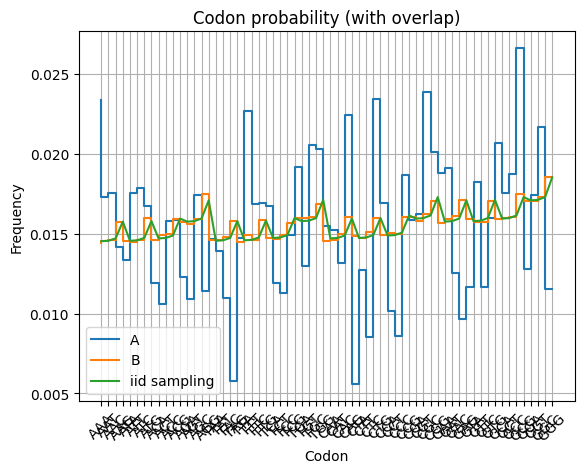

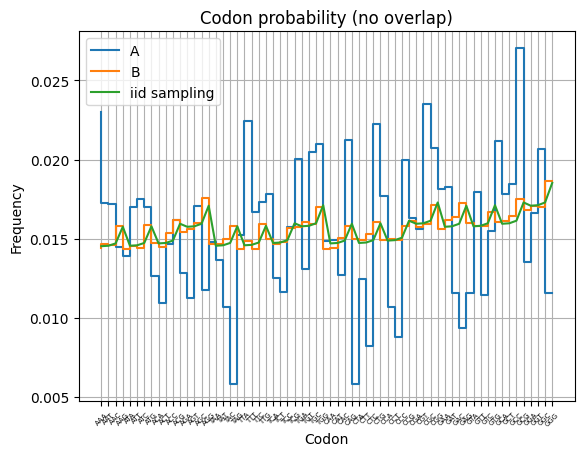

In [11]:
step_plot('Codon probability (with overlap)', [A_codons, B_codons], ['A', 'B'], toplot_asline=[iid_codons], labels_asline=['iid sampling'],
         xlabel='Codon', ylabel='Frequency')

step_plot('Codon probability (no overlap)', [A_codons_no_overlap, B_codons_no_overlap], ['A', 'B'], toplot_asline=[iid_codons], 
          labels_asline=['iid sampling'], xlabel='Codon', ylabel='Frequency')

First of all we notice the distributions doesn't change whether we consider or not the overlap of the subchains. Then we notice that the distribution from file B resembles very much that of random iid sampling. **This is our first hint that file A is the real genome**

(I don't really see the use of the following, but I wanted to check we're not missing anything)

In [12]:
def big_differences(Z_codons, Z_codons_no_overlap, tol):
    '''Tells if counting codons allowing or not the overlap of subchains makes a significance difference.'''
    for k in Z_codons.keys():
        dif = Z_codons[k] - Z_codons_no_overlap[k]
        if np.abs(dif) > tol:
            if dif>0:
                whichIsGreater='prob. with overlap is greater'
            else:
                whichIsGreater='prob. with no overlap is greater'
            print(f'{k}, difference is {np.abs(dif)}, {whichIsGreater}')
    # If the max difference is less than tol, then say it
    if max([np.abs(Z_codons[k]-Z_codons_no_overlap[k]) for k in Z_codons.keys()]) < tol:
        print(f'None (all differences are less than {tol})')

tol=1e-3 # An (arbitrary) difference in probability that is considered significant
print(f'Codons whose probability differ by more than {tol} when counted with or with no overlap')
print('-> In file A:')
big_differences(A_codons, A_codons_no_overlap,tol)
print('-> In file B:')
big_differences(B_codons, B_codons_no_overlap,tol)

Codons whose probability differ by more than 0.001 when counted with or with no overlap
-> In file A:
ACC, difference is 0.0010905930932899564, prob. with overlap is greater
TCA, difference is 0.0010416368499511289, prob. with no overlap is greater
CAG, difference is 0.001173157551631835, prob. with overlap is greater
CTG, difference is 0.001133408548969917, prob. with overlap is greater
CCG, difference is 0.0012566925839809853, prob. with no overlap is greater
-> In file B:
None (all differences are less than 0.001)


(As stated before, the difference is rather small)

### Testing a null hypothesis

Null hypothesis: the file can be regarded as a sequential series of codons (triplets) sampled from an iid multinomial distribution with  probability $p(N_1, N_2, ..., N_n) \approx p(N_1) p(N_2) \cdots p(N_n)$ for each codon $N_1 N_2 N_3$. 

Thus, we can compute the probability of obtaining the observed $x_i$ counts (no overlap) for each codon i, given the null hypothesis. 

Recall the multinomial distribution for n trials and k categories is:
$$ p(x_1, x_2, ..., x_k; n) = n! \frac{\prod_{i}^{k} p_i^{x_i}}{\prod_i^k x_i!} $$

We will compute the log of this probability

In [13]:
math.log(64)

4.1588830833596715

In [14]:
n=N//3    # Number of codons
p=4**(-3) # Approximate robability of a codon

def log_prob(A_codons_no_overlap):
    sum_log_xi_fact = 0                            # \sum_i log(x_i)!
    sum_xi_log_pi = 0                              # \sum_i (x_i \log(p_i))
    for k in A_codons_no_overlap.keys():
        x = A_codons_no_overlap[k]*n 
        sum_log_xi_fact += x*math.log(x)-x #Using Stirling
        pi = iid_codons[k]
        sum_xi_log_pi += x*math.log(pi)
    log_nfact = n*math.log(n)-n                     # log(n!), using Stirling
    return (log_nfact+sum_xi_log_pi-sum_log_xi_fact)

A_logprob = log_prob(A_codons_no_overlap)
B_logprob = log_prob(B_codons_no_overlap)

print(f'A has a prob to occur of e^{int(A_logprob)}, while B has a prob to occur of e^{int(B_logprob)}')
print(f'Sample space is 64^{n}, approximately e^{n*int(math.log(64))}')

A has a prob to occur of e^-12334, while B has a prob to occur of e^-34
Sample space is 64^327044, approximately e^1308176


Based on the definition of the p-value, we will define it as the probability to observe a deviation from the null hypothesis at least as extreme as that observed in the data. Looking at our data, the value that deviates the most from the multinomial distribution is that of the codon GCG. What is the probability of obtaining at least those many times the codon GCG given the null hypothesis?

In [17]:
def deviation_from_iid(Z_codons_no_overlap):
    '''Return the codon with max deviation from iid probabilities and the number of times it appears '''
    Z_deviations = [(Z_codons_no_overlap[k]-iid_codons[k]) for k in iid_codons.keys()]
    #Z_deviations = [np.abs(Z_codons_no_overlap[k]-iid_codons[k]) for k in iid_codons.keys()]
    max_deviation = max(Z_deviations)
    max_codon_index = Z_deviations.index(max_deviation)
    max_codon = list(Z_codons_no_overlap.keys())[max_codon_index]
    max_prob = Z_codons_no_overlap[max_codon]
    iid_prob = iid_codons[max_codon]
    return max_codon, math.floor(max_prob*n), math.floor(iid_prob*n), iid_prob

def compute_pvalue(Z_md_realn, Z_md_predictedn, Z_hyp_prob):
    ''' Returns probability of observing a result at least as extreme as that observed given the sampling comes from Multinomial trials. 
        If the observed result is greater than expected, returns the 1- cummulative probability, else returns the cummulative probability'''
    CDFprob = scipy.special.betainc(n-Z_md_realn, 1+Z_md_realn, 1-Z_hyp_prob)
    if Z_md_realn > Z_md_predictedn:
        return 1-CDFprob
    else:
        return CDFprob

A_md_codon, A_md_n, A_md_iid_n, A_md_iid_p = deviation_from_iid(A_codons)
B_md_codon, B_md_n, B_md_iid_n, B_md_iid_p = deviation_from_iid(B_codons)

print('File \t codon with max deviation \t appears \t predicted to appear')
print(f'A \t {A_md_codon} \t \t \t \t {A_md_n} \t \t {A_md_iid_n}')
print(f'B\t {B_md_codon} \t \t \t \t {B_md_n} \t \t {A_md_iid_n} \n')

print(f'p-value for A: {compute_pvalue(A_md_n, A_md_iid_n, A_md_iid_p)}')
print(f'p-value for B: {compute_pvalue(B_md_n, B_md_iid_n, B_md_iid_p)}')

File 	 codon with max deviation 	 appears 	 predicted to appear
A 	 GCG 	 	 	 	 8700 	 	 5653
B	 AGG 	 	 	 	 5711 	 	 5653 

p-value for A: 1.1102230246251565e-16
p-value for B: 0.04606135808877687


So the null hypothesis can be discarded for file A and for file B the test is not conclusive.

## Conditional probabilities

Another expected feature of a non-random nucleotide sequence would be that the appearance of a nucleotide in a codon is not independent of the rest of the nucleotides in the codon. 
Thus for example, the sequence AAA would not be equally likely as the sequence AAG. 

We will test the following null hypothesis: the sampling process of nucleotides in the sequences is at most (in terms of its memory capacity) Markovian. 

We already took a step by proving a less strict null hypothesis: The sampling process of nucleotides in the sequences is iid. This is, $p(N1, N2, N3) = p(N1) p(N2) p(N3)$

We will now attempt to falsify a Markovianity null hypothesis, that is, that: $$p(N1, N2, N3) = p(N1, N2) p(N3|N1, N2) = p(N1) p(N2|N1) p(N3|N1, N2) =  p(N1) p(N2|N1) p(N3|N2)$$

In [18]:
# Functions to compute (empirical) conditional probabilities

def probN2_givenN1(Z,N1,N2):
    ''' Compute p(N2|N1) '''
    num_N1=0
    num_N1_N2=0
    for i in range(len(Z)-1):
        if Z[i] == N1:
            num_N1 += 1
            if Z[i+1] == N2:
                num_N1_N2 += 1
    return num_N1_N2/num_N1


def probN3_givenN1N2(Z,N1,N2,N3):
    ''' Compute p(N3|N1, N2) '''
    num_N1N2=0
    num_N1N2_N3=0
    for i in range(len(Z)-2):
        if Z[i] == N1 and Z[i+1]==N2:
            num_N1N2 += 1
            if Z[i+2] == N3:
                num_N1N2_N3 += 1
    return num_N1N2_N3/num_N1N2

In [19]:
# Initialize containers for conditional probabilities p(N2|N1) and for empirical probabilites p(N1, N2)
A_simple_conditionals, B_simple_conditionals,iid_duplets = ({}, {},{})

# Iterate over all possible duplets (4^2 of them)
for i in itertools.product(['A','T', 'C', 'G'], ['A','T', 'C', 'G']):
    duplet= ''.join(i)
    A_simple_conditionals[duplet]=probN2_givenN1(A,i[0],i[1])
    B_simple_conditionals[duplet]=probN2_givenN1(B,i[0],i[1])
    iid_duplets[duplet] = B_single_probs[i[0]]*B_single_probs[i[1]]

# Same for conditional probabilities p(N3|N1,N2) (empirical probabilities p(N1,N2,N3) are already stored in iid_codons).
A_double_conditionals, B_double_conditionals = ({}, {})
# Use the same loop to compute the "Markovian" probabilities p(N1) p(N2|N1) p(N3|N2)
# as well as the probabilities p(N1, N2) p(N3|N1, N2) which consider a "memory" in considering p(N3|N1, N2) != p(N3|N2)
A_Markovian, A_memory = ({},{})
B_Markovian, B_memory = ({},{})
# Iterate over all possible codons (4^3 of them)
for i in itertools.product(['A','T', 'C', 'G'], ['A','T', 'C', 'G'], ['A','T', 'C', 'G']):
    codon= ''.join(i)
    N1N2N3 = codon #I define this for ease of notation
    N1N2 = i[0]+i[1]
    N2N3 = i[1]+i[2]
    
    A_double_conditionals[codon]=probN3_givenN1N2(A,i[0],i[1],i[2])
    A_Markovian[codon] = A_single_probs[i[0]]*A_simple_conditionals[N1N2]*A_simple_conditionals[N2N3]
    A_memory[codon] = A_single_probs[i[0]]*A_simple_conditionals[N1N2]*A_double_conditionals[N1N2N3]

    B_double_conditionals[codon]=probN3_givenN1N2(B,i[0],i[1],i[2])
    B_Markovian[codon] = B_single_probs[i[0]]*B_simple_conditionals[N1N2]*B_simple_conditionals[N2N3]
    B_memory[codon] = B_single_probs[i[0]]*B_simple_conditionals[N1N2]*B_double_conditionals[N1N2N3]



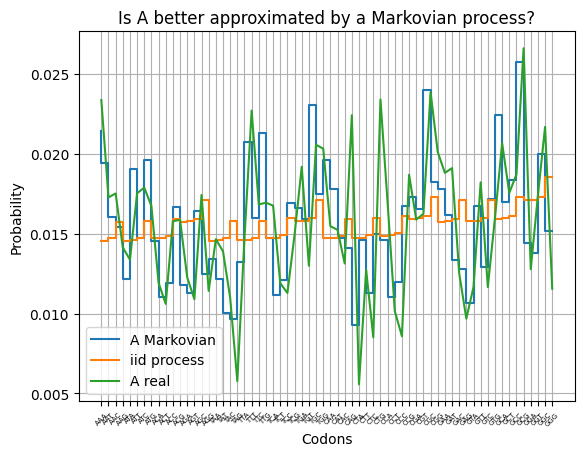

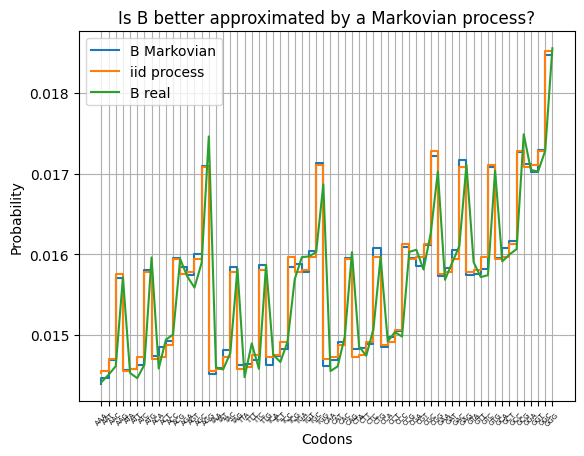

In [20]:
step_plot('Is A better approximated by a Markovian process?', [A_Markovian, iid_codons], ['A Markovian', 'iid process'],
          toplot_asline=[A_codons], labels_asline=['A real'], xlabel='Codons', ylabel='Probability')

step_plot('Is B better approximated by a Markovian process?', [B_Markovian, iid_codons], ['B Markovian', 'iid process'],
          toplot_asline=[B_codons], labels_asline=['B real'], xlabel='Codons', ylabel='Probability')

We can see that the codon probability distribution for A is better approximated by a Markovian process, and for B the difference between Markovian and memoryless (iid) is very small. 

We further test our Null hypothesis (namely, that codons are approximately sampled from a Markovian process), using the same method as before

In [21]:
def deviation_from_real(Z_compare, Z_real):
    ''' Similar to deviation_from_iid, admits a different reference probability distribution Z_real 
        and return the bigger deviation from Z_compare to Z_real.
        Returns: (codon with max deviation (str), number of times the codon appears in Z_real (int), number of times the codon was expected to appear (int)'''
    Z_deviations = [np.abs(Z_compare[k]-Z_real[k]) for k in iid_codons.keys()]
    max_deviation = max(Z_deviations)
    max_codon_index = Z_deviations.index(max_deviation)
    max_codon = list(Z_compare.keys())[max_codon_index]
    max_prob = Z_real[max_codon]
    compare_prob = Z_compare[max_codon]
    return max_codon, math.floor(max_prob*n), math.floor(compare_prob*n), compare_prob

# Store max deviations from the empirical distributions and the Markovian/iid hypotheses
# together with the expected amount of times the max deviated codon would appear under the hypothesis
#- Markovian hypothesis
B_md_Mark_codon, B_md_Mark_realn, B_md_Mark_n, B_md_Mark_p  = deviation_from_real(B_Markovian, B_codons)
A_md_Mark_codon, A_md_Mark_realn, A_md_Mark_n, A_md_Mark_p = deviation_from_real(A_Markovian, A_codons)
#- iid hypotehsis
B_md_iid_codon, B_md_iid_realn, B_md_iid_n, B_md_iid_p = deviation_from_real(iid_codons, B_codons)
A_md_iid_codon, A_md_iid_realn, A_md_iid_n, A_md_iid_p = deviation_from_real(iid_codons, A_codons)

print('Hypothesis \t codon with max deviation \t appears \t predicted to appear')
print(f'A iid \t \t {A_md_iid_codon} \t \t \t \t {A_md_iid_realn} \t \t {A_md_iid_n}')
print(f'A Markovian \t {A_md_Mark_codon} \t \t \t \t {A_md_Mark_realn} \t \t {A_md_Mark_n} \n')
print(f'B iid \t \t {B_md_iid_codon} \t \t \t \t {B_md_iid_realn} \t \t {B_md_iid_n}')
print(f'B Markovian \t {B_md_Mark_codon} \t \t \t \t {B_md_Mark_realn} \t \t {B_md_Mark_n} \n')

# Compute p-values
A_p_value_Mark = compute_pvalue(A_md_Mark_realn, A_md_Mark_n, A_md_Mark_p)
B_p_value_Mark = compute_pvalue(B_md_Mark_realn, B_md_Mark_n, B_md_Mark_p )
A_p_value_iid = compute_pvalue(A_md_iid_realn, A_md_iid_n, A_md_iid_p)
B_p_value_iid = compute_pvalue(B_md_iid_realn, B_md_iid_n, B_md_iid_p)
#B_p_value_iid = 1-scipy.special.betainc(n-B_md_iid_n, 1+B_md_iid_n, 1-B_iid_prob)


# print(f'p-value for A: {A_p_value}')


print('p-values:')

print(f'A Markovian: \t {A_p_value_Mark}')
print(f'B Markovian: \t {B_p_value_Mark}')
print(f'A iid: \t \t {A_p_value_iid}')
print(f'B iid: \t \t {B_p_value_iid}')

Hypothesis 	 codon with max deviation 	 appears 	 predicted to appear
A iid 	 	 TAG 	 	 	 	 1887 	 	 5161
A Markovian 	 CTG 	 	 	 	 7651 	 	 4909 

B iid 	 	 AGG 	 	 	 	 5711 	 	 5586
B Markovian 	 AGG 	 	 	 	 5711 	 	 5589 

p-values:
A Markovian: 	 1.1102230246251565e-16
B Markovian: 	 0.04998917587915863
A iid: 	 	 0.0
B iid: 	 	 0.04606135808877687


Again, we discard the Null hypothesis for A and catalogue the test as non-conclusive for B

## Entropy of subchains (considering n-letter words)

Now I will split the files in sqrt(N) subchains of size sqrt(N) each. I expect the "real" DNA data to have regions that are more informative than others, thus having lower entropy. On the other hand, the random permutation would have approximately the same entropy across all subchains, approximately equal to that of the whole chain.

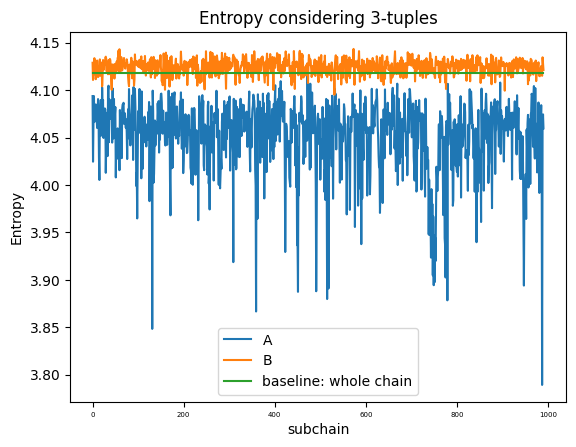

In [24]:
# For word length = 1, the whole-chain entropy is close to that of the uniform distribution. 
# For word length = 2, the case is similar to that of word_length=2, but word_length=3 is more meaningful
word_length=3
sqrtN = math.floor(math.sqrt(N))

def entropy(chain,word_length=1):
    ''' Estimates n-letter word entropy of a given chain '''
    Shannon=0
    for i in itertools.product(['A','T', 'C', 'G'], repeat=word_length):
        if ''.join(i) in chain:
            prob = prob_ntuple(chain,''.join(i))             # Get p(x_i)
            Shannon -= prob * math.log(prob)                 # (sum_i) -x_i p(x_i)
    return Shannon
    
# Initialize containers for entropies of subchains
A_entropies, B_entropies = ([],[])
# Iterate over subchains
for i in range(0,N-sqrtN,sqrtN):
    A_subchain = A[i:i+sqrtN]
    B_subchain = B[i:i+sqrtN]
    # Estimate the entropy of the subchain
    A_entropies.append(entropy(A_subchain,word_length=word_length))
    B_entropies.append(entropy(B_subchain,word_length=word_length))

# Plot them xP
plt.plot(A_entropies,label='A')
plt.plot(B_entropies,label='B')
plt.plot([entropy(A,word_length=word_length)]*sqrtN, label='baseline: whole chain')
#plt.plot([np.log(4)]*sqrtN
plt.ylabel('Entropy')
plt.xlabel('subchain')
plt.title(f'Entropy considering {word_length}-tuples')
plt.legend(loc='best')



### Null hypothesis

Null hypothesis: The entropy of the subchains is an iid RV following a normal distribution (through the law of large numbers, given that $\sqrt{N}$ is sufficiently large)

Alternative hypothesis: the entropy of the subchains is determined by the (genetically meaningful) content of the subchain.

We will test the null hypothesis by estimating the Kullback-Leibler divergence between the empirical distribution and a normal distribution with equal mean and variance. 

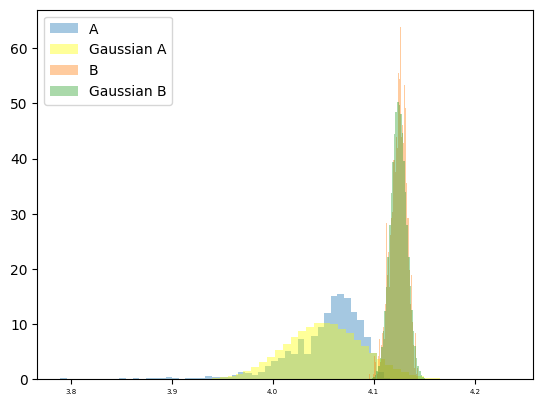

D_KL between Gaussian and A is 2.1709489502987878 and between Gaussian and B it's 0.5005265672891943, 
D_KL between A and B is 0.8670076951496133 and between both Gaussians it's 0.031024560666442075


In [27]:
# Normal distributions, to compare them to the results
gaussA=np.random.normal(np.mean(A_entropies), np.std(A_entropies), 1000000)
gaussB=np.random.normal(np.mean(B_entropies), np.std(B_entropies), 1000000)

# Plot the distributions
A_entorpies_probs = plt.hist(A_entropies, alpha=0.4,label='A',bins=50,density=True)
gaussA_probs = plt.hist(gaussA, alpha=0.4, label='Gaussian A',bins=50, color='yellow',density=True)
B_entropies_probs = plt.hist(B_entropies, alpha=0.4, label='B',bins=50,density=True)
gaussB_probs = plt.hist(gaussB, alpha=0.4, label='Gaussian B',bins=50,density=True)
plt.legend(loc='best')
plt.show()

# Function to estimate KL-divergence
def DKL(a, b):
    a = np.asarray(a)/np.sum(a) # Normalize the distributions 
    b = np.asarray(b)/np.sum(b)
    relent = 0              # Container for relative entropy
    for i in range(len(b)):
        if (a[i]!=0 and b[i]!=0):
            relent+= a[i]*np.log(a[i]/b[i])  # (\sum_i) p(x_i) log(p(x_i)/q(x_i))
    return relent                            


DKL_A = DKL(gaussA_probs[0],A_entorpies_probs[0])        # Between gaussian and A
DKL_B = DKL(gaussB_probs[0], B_entropies_probs[0])       # Between gaussian and B
DKL_AB = DKL(B_entropies_probs[0],A_entorpies_probs[0])  # Between B and A
DKL_gaussAB = DKL(gaussA_probs[0], gaussB_probs[0])      # Between gaussians

print(f"D_KL between Gaussian and A is {DKL_A} and between Gaussian and B it's {DKL_B}, \nD_KL between A and B is {DKL_AB} and \
between both Gaussians it's {DKL_gaussAB}")

We can interpret these results in the following way: 
The probability distribution for the entropy of subchains in file B is closer to being a Gaussian distribution than what A is. Thus, B is closer to satisfying the null hypothesis than A is. 

# Conclusion

The real file is most certainly file A. 
File B appears to have a random structure. Science does not allow us to state this with a 100% confidence (anyway what is randomness), but we can gain a strong confidence that file A does not have a random structure, so we can safely conclude that, if we trust our professor in that either file A and file B contains the genome for E. Coli, then it's file A the one with the genome. 